## Dursun Dashdamirov

## Loading libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import missingno
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import estimator_html_repr
from IPython.core.display import HTML
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

## Loading data

In [55]:
tipdata = sns.load_dataset('tips')

In [56]:
tipdata.head(7)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2


In [57]:
tipdata.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [58]:
tipdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [59]:
tipdata.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

## Visualizations

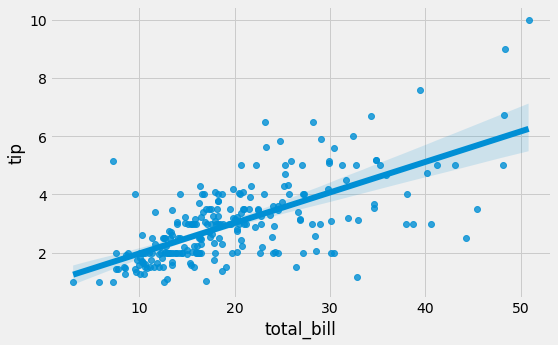

In [60]:
fig, ax = plt.subplots(figsize=(8,5))

sns.regplot(tipdata['total_bill'], tipdata['tip'])

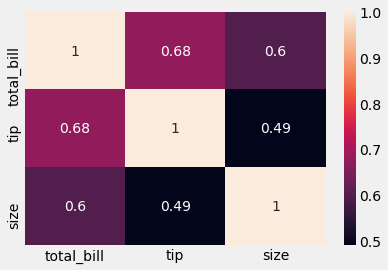

In [61]:
tcorr = tipdata.corr()
sns.heatmap(tcorr, annot=True)

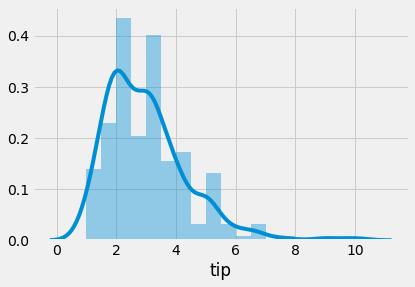

In [62]:
sns.distplot(tipdata['tip'])

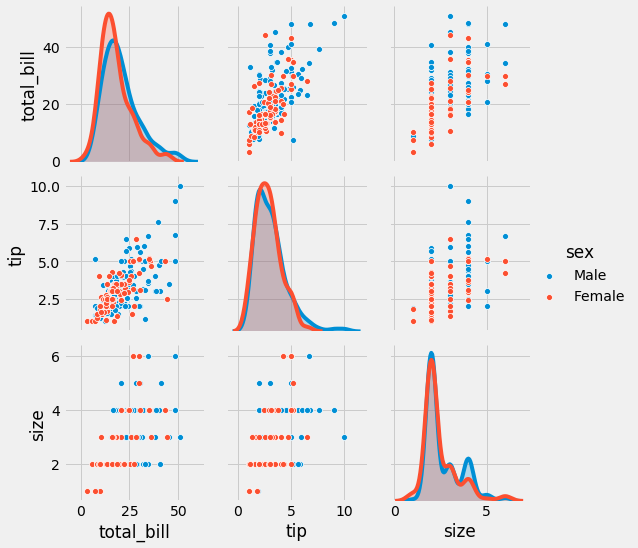

In [63]:
sns.pairplot(data=tipdata,hue='sex')
plt.show()

## Feature engineering 

In [64]:
columns_to_encode = ["sex","smoker","time"]
columns_to_scale = ["total_bill","tip","size"]

In [65]:
df = pd.concat([tipdata, pd.get_dummies(tipdata["day"],prefix="day")], axis=1)
df.head()

,total_bill,tip,sex,smoker,day,time,size,day_Thur,day_Fri,day_Sat,day_Sun
0,16.99,1.01,Female,No,Sun,Dinner,2,0,0,0,1
1,10.34,1.66,Male,No,Sun,Dinner,3,0,0,0,1
2,21.01,3.50,Male,No,Sun,Dinner,3,0,0,0,1
3,23.68,3.31,Male,No,Sun,Dinner,2,0,0,0,1
4,24.59,3.61,Female,No,Sun,Dinner,4,0,0,0,1


In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["sex"]=pd.DataFrame(le.fit_transform(df["sex"]))

In [67]:
df["time"]=pd.DataFrame(le.fit_transform(df["time"]))
df["smoker"]=pd.DataFrame(le.fit_transform(df["smoker"]))

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_columns = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]),columns=columns_to_scale)
scaled_columns.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,0.350145,0.222031,0.313934
std,0.186477,0.153738,0.190220
min,0.000000,0.000000,0.000000
25%,0.215281,0.111111,0.200000
50%,0.308442,0.211111,0.200000
75%,0.441087,0.284722,0.400000
max,1.000000,1.000000,1.000000


In [69]:
df.drop(["total_bill","tip","size", "day"],axis=1,inplace=True)
df = pd.concat([df, scaled_columns], axis=1)
df.head(7)

,sex,smoker,time,day_Thur,day_Fri,day_Sat,day_Sun,total_bill,tip,size
0,0,0,0,0,0,0,1,0.291579,0.001111,0.2
1,1,0,0,0,0,0,1,0.152283,0.073333,0.4
2,1,0,0,0,0,0,1,0.375786,0.277778,0.4
3,1,0,0,0,0,0,1,0.431713,0.256667,0.2
4,0,0,0,0,0,0,1,0.450775,0.290000,0.6
5,1,0,0,0,0,0,1,0.465438,0.412222,0.6
6,1,0,0,0,0,0,1,0.119397,0.111111,0.2


### New correlation map with categorical values:

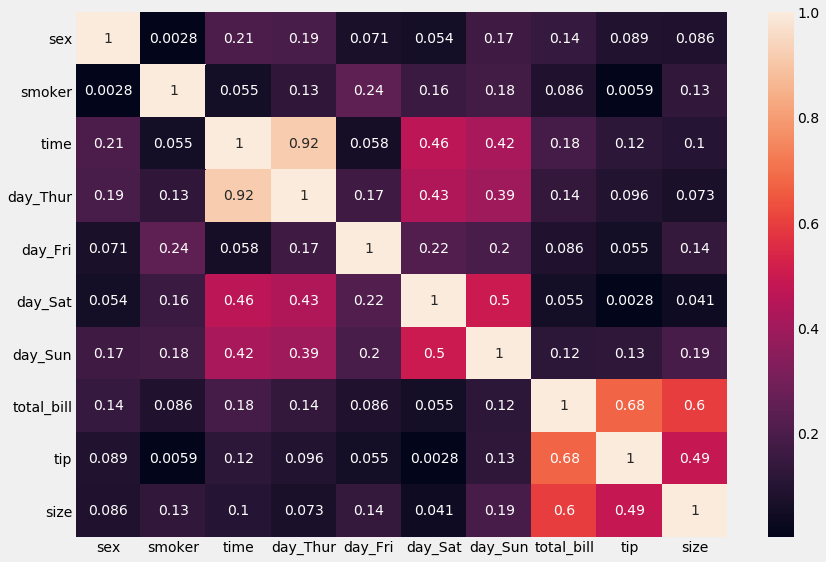

In [70]:
correlation = df.corr().abs()
plt.figure(figsize=(13,9))
sns.heatmap(correlation, annot=True)
plt.show()

## Preparing data for regression

In [71]:
target = df.tip
features = df.loc[:,df.columns!="tip"]

In [72]:
from sklearn.feature_selection import SelectKBest
kbest = SelectKBest(k=5)
k_best_features = kbest.fit_transform(features, target)
list(df.columns[kbest.get_support (indices=True)])

['sex', 'day_Sat', 'day_Sun', 'total_bill', 'tip']

In [73]:
#also checking Pearson correlation
df.corrwith(df["tip"]).abs().nlargest(6)


tip           1.000000
total_bill    0.675734
size          0.489299
day_Sun       0.125114
time          0.121629
day_Thur      0.095879
dtype: float64

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [75]:
from sklearn.linear_model import LinearRegression
linearreg = LinearRegression()
linearreg.fit(X_train, y_train)
pred = linearreg.predict(X_test)

In [76]:
print("Coefficients: \n", linearreg.coef_)
print("Intercept: \n", linearreg.intercept_)

Coefficients: 
 [-0.00712729 -0.01276638  0.01475352 -0.01497932  0.01215682 -0.00211106
  0.00493357  0.44418911  0.14137784]
Intercept: 
 0.021505496307221594


In [77]:
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred)**0.5
r2 = r2_score(y_test, pred)


print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

MSE    : 0.02 
MAE    : 0.08 
RMSE   : 0.12 
R2     : 0.44 


 We could get better results with different regression techinuqes or we could spent more time on Feature engineering. Since the correlation between variables and tip is not prefect, this scores are also acceptable.